# Predicting the Price of New York City Airbnbs
DSCI 310: Group 9

By Oliver Gullery, Prithvi Sureka, Riddhi Battu, Rashi Selarka

In [3]:
#dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import folium
import os

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import requests
from branca.colormap import linear
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer


# Summary

We are developing a classification model using a KNN machine learning algorithm to categorize Airbnb listing prices into various ranges. The goal is to accurately assign each listing to a price bracket, starting at $0 and increasing in $50 increments up to $350 and above. The classifier is designed to help potential guests estimate the price range of a rental before detailed information is provided. The performance of our model on the test data set indicates varying degrees of precision and recall across different price categories, with an overall accuracy of 0.51. Given that the data set consists of 7926 instances, the model shows promise, but there is significant room for improvement. Particular attention should be given to enhancing the performance for categories that currently show lower F1-scores. Further analysis is needed to understand the features that most affect price prediction accuracy and to refine the model for better performance across all price ranges.

# Introduction

Airbnb has been one of the most popular short-term stays and rental online services since 2008, expanding to over a thousand cities in less than a year (Geron, 2009). Owing to its exponential growth however, many metropolises such as Paris, London, Berlin, and New York City started introducing special rules and laws for creating a listing on Airbnb due to its impact on housing shortages and rental markets (Tun, 2023). In September 2023, New York enforced a measure called Local Law 18 (Oladipo, 2023), that was essentially a de facto ban on short-term rentals that would force the amount of listings to decrease 85% within the month (Chan, 2023), and decrease over 90% as of 2024 from what they were in 2022 (Bellafante, 2024). Consequently, this led average prices to surge, and led us to want to investigate factors of New York Airbnbs and how they impact listing prices.

We were able to obtain a workable and descriptive dataset about New York Airbnbs from [insideairbnb.com](http://insideairbnb.com/new-york-city/) (New York City, 2024) that gave insight into every listing from 2011 to 2023 and their reviews. The fields present in our dataset are:

* ID: Unique identifier for listing
* Name: Name of listing, followed by rating and type (e.g. 1 bed 1 bath)
* Host ID: Unique identifier for host
* Host Name: Name of host
* Neighbourhood: Neighbourhood where listing is located
* Neighbourhood Group: Borough where listing is located
* Latitude: Latitudinal coordinate of listing location
* Longitude: Longitudinal coordinate of listing location
* Room Type: Listing space type (Private room, Entire home / Apt., etc.)
* Price: Price per Night in USD
* Minimum Nights: Minimum nights required to stay at the rental
* Number of Reviews: Total number of reviews on the listing
* Last Review: Date of latest review on the rental
* Reviews Per Month: Avg. monthly number of reviews on the listing
* Calculated Host Listings Count: Number of listings the corresponding host has
* Availability 365: Number of days in a year listing is available for booking

Here we intend to use a machine learning algorithm to predict Airbnb prices per night using most of the above factors. There have been multiple studies looking into how the Airbnb ban impacts NYC rental (Fields, 2023) and hotel prices (Kelly, 2023), but not as much into the Airbnb prices themselves. Since our investigation will be solely based on data up until 2023, it can be used glean exactly how these restrictions impacted Airbnb prices in NYC when compared with information from 2024 onwards (i.e. was it because the number of listings per host went down? Or was it because the minimum number of nights required to stay went up? and more questions like that). As Airbnb prices can range to various amounts, we will look to *bin prices into different categories in increments of 50*. This will help us provide a more accurate range of price recommendations when looking at different Airbnb listings

# Methods

## 1. Data

### 1.1 Loading + Exporting Data to csv

In [4]:
# loading the data
url_listings = "http://data.insideairbnb.com/united-states/ny/new-york-city/2023-12-04/visualisations/listings.csv"

data = pd.read_csv(url_listings)
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Rental unit in New York · ★4.68 · Studio · 1 b...,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240,30,49,2022-06-21,0.29,3,339,0,NaN
1,5121,Rental unit in Brooklyn · ★4.52 · 1 bedroom · ...,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,66,30,50,2019-12-02,0.28,2,88,0,NaN
2,6848,Rental unit in Brooklyn · ★4.58 · 2 bedrooms ·...,15991,Allen & Irina,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81,30,191,2023-08-14,1.08,1,142,4,NaN


In [16]:
# saving the data file to /data/raw
data.to_csv("../data/raw/airbnb_data_2023.csv", index=False)

## 2. Exploratory Data Analysis

### 2.1 Preliminary EDA

In [17]:
# Data shape & datatypes
print(f'Data Shape: {data.shape}\n')
print(f'Data datatypes: \n{data.dtypes}')

Data Shape: (39627, 18)

Data datatypes: 
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object


### 2.2 Summary Statistics

In [7]:
data.info()

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39627 entries, 0 to 39626
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39627 non-null  int64  
 1   name                            39627 non-null  object 
 2   host_id                         39627 non-null  int64  
 3   host_name                       39612 non-null  object 
 4   neighbourhood_group             39627 non-null  object 
 5   neighbourhood                   39627 non-null  object 
 6   latitude                        39627 non-null  float64
 7   longitude                       39627 non-null  float64
 8   room_type                       39627 non-null  object 
 9   price                           39627 non-null  int64  
 10  minimum_nights                  39627 non-null  int64  
 11  number_of_reviews               39627 non-null  int64  
 12  last_review                     

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,3.962700e+04,3.962700e+04,39627.000000,39627.000000,39627.000000,39627.000000,39627.000000,28147.000000,39627.000000,39627.000000,39627.000000
mean,3.083450e+17,1.602573e+08,40.729360,-73.946072,208.816464,30.051127,25.251520,1.021708,41.852197,153.721276,6.264088
std,4.050888e+17,1.717839e+08,0.056425,0.054788,482.380712,29.290027,57.718207,1.716199,124.056880,147.391076,16.602446
min,2.595000e+03,1.678000e+03,40.500314,-74.251907,8.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.023932e+07,1.692691e+07,40.688980,-73.982785,75.000000,30.000000,0.000000,0.110000,1.000000,0.000000,0.000000
50%,4.650264e+07,8.066903e+07,40.726520,-73.954090,127.000000,30.000000,4.000000,0.390000,1.000000,122.000000,0.000000
75%,7.564324e+17,2.857275e+08,40.762667,-73.926560,214.000000,30.000000,22.000000,1.415000,6.000000,319.000000,4.000000
max,1.037983e+18,5.491316e+08,40.911380,-73.713650,30000.000000,1250.000000,1857.000000,71.160000,691.000000,365.000000,983.000000


### 2.3 Identifying Null Values & Duplicates

In [19]:
print(f'Null Values: {data.isna().sum()}\n')
print(f'Duplicated Values: {data.duplicated().sum()}')

Null Values: id                                    0
name                                  0
host_id                               0
host_name                            15
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       11480
reviews_per_month                 11480
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           35268
dtype: int64

Duplicated Values: 0


In [20]:
# minor statistics about License
print(f'License Summary Statistics: \n{data["license"].describe()}')

License Summary Statistics: 
count       4359
unique       700
top       Exempt
freq        3408
Name: license, dtype: object


### 2.4 Correlations between Numerical Data (Top 10)

In [18]:
# creating correlation matrix from numeric data (exlucding host_id and id)
corr_matrix = data.select_dtypes(include=["int64", "float64"]).drop(['host_id','id'], axis=1).corr()

def rank_correlations(corr_matrix):
    # flattening matrix
    flattened_matrix = corr_matrix.stack().reset_index()
    #renaming columns
    flattened_matrix.columns = ['Variable_1', 'Variable_2', 'Correlation']
    # removing duplicate variable names
    flattened_matrix = flattened_matrix.loc[flattened_matrix['Variable_1'] != flattened_matrix['Variable_2']]
    corr_column = flattened_matrix['Correlation']
    flattened_matrix = flattened_matrix.iloc[abs(corr_column).argsort()[::-1]]
    flattened_matrix = flattened_matrix.loc[flattened_matrix['Correlation'].duplicated()]
    #print(f'Top 10 Variable Correlations: \n{flattened_matrix.head(10)}')
    return flattened_matrix.head(10)

rank_correlations(corr_matrix)

,Variable_1,Variable_2,Correlation
77,number_of_reviews_ltm,reviews_per_month,0.859984
49,reviews_per_month,number_of_reviews,0.646637
76,number_of_reviews_ltm,number_of_reviews,0.645866
61,calculated_host_listings_count,availability_365,0.137655
52,reviews_per_month,availability_365,0.130711
42,number_of_reviews,calculated_host_listings_count,-0.129957
19,price,longitude,-0.117793
78,number_of_reviews_ltm,calculated_host_listings_count,-0.109144
32,minimum_nights,reviews_per_month,-0.106898
46,reviews_per_month,longitude,0.088384


**Fig. 1 Correlation Heat Map of Numerical Predictors**

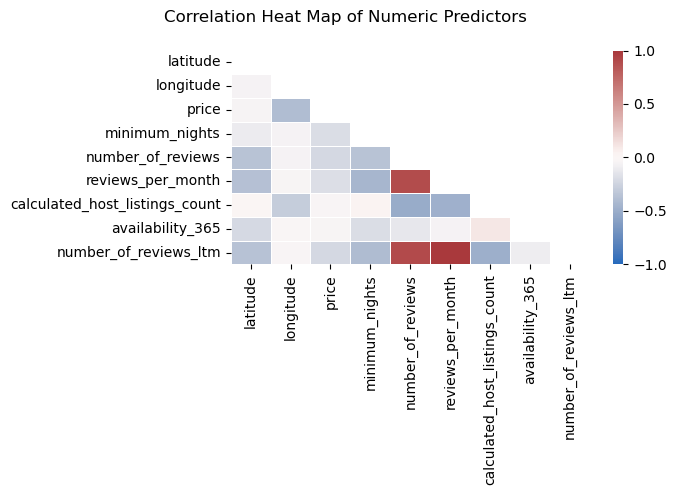

In [51]:
# Fig. 1

train_corr = corr_matrix.corr(method = 'pearson')
mask = np.zeros_like(train_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(7, 5))

sns.heatmap(train_corr, mask=mask, vmin=-1, vmax=1, center=0, linewidths=.5, cmap="vlag")
fig.suptitle('Correlation Heat Map of Numeric Predictors', fontsize=12)
fig.tight_layout()

### 2.5 Takwaways From Preliminary EDA

- Our shape function tells us we have 39627 rows and 18 features which includes our target variable `price`. 

- Looking at the columns from our info() function we can identify that name is a text type data which could provide some valuable insights. We can also infer that any id information (`id` and `host_id`) and variables such as `host_name` will not provide any key information, thus, we can drop them for our data analysis.

- The describe() function provided key summary statistics for our numeric columns which included the following metrics: count, mean, standard deviation, minimum, and maximum. This helps us better understand the spread of our data. Our info() function gave us further information about the datatypes, columns, and amount of data we have.

- Our isna() function informed us of the null values which are included in the dataset. The columns `host_name` has *15* null values but this is irrelevant as we will drop this column. Our `reviews_per_month` column and `last_review` column have *11480* null values each. This suggests that when a airbnb listing doesn't have a review, it was listed as a null value in the data. To fix this we could impute 0 into the nulls for `reviews_per_month`. For `last_review`, we decided it would be appropriate to drop the column as some of the information it provides is stored in reviews per month.

- `license` has a significant number of null values with 35268. It might provide some interesting insights into price as a license is proof that the airbnb owners comply with the regulatory standards, but since the nature of these missing values is unknown, we cannot be sure if the null values means the listing has no license. Due to this imbalance in the data, we decided it best to drop this column. However, it could be worth exploring the relationship between license and other variables in future analyses.

### 2.6 Next Steps for Feature Engineering

In order to prepare our data for further analysis we must perform some preliminary feature engineering which will involve:
- Convert `id` and `host_id` into object datatypes to prepare them to be dropped.
- Impute zeros into the `reviews_per_month` null values.
- Segregate fields into target column, categorical, numerical, text data, and drop data.
- Split the data into training and test sets.
- Create out price category variable

## 3. Feature Engineering

### 3.1 Convert `id` and `host_id` into object datatypes to prepare them to be dropped.

In [24]:
data['id'] = str(data['id'])
data['host_id'] = str(data['host_id'])

### 3.2 Impute zeros into the `reviews_per_month` column for null values.

In [25]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

### 3.3 Segregate fields into target column, categorical, numerical, text, and drop data.

In [26]:
# target column
target_data = ['price']

# numeric data
numerical_data = data.select_dtypes(include=["int64", "float64"]).drop(target_data, axis=1)
numerical_data = numerical_data.columns

# text data
text_data = ["name"]

# drop data
drop_data = ["host_name", "host_id", "id", "license", "last_review"]

# Categorical Data
categorical_data = data.select_dtypes(include=["object"])
categorical_data = categorical_data.columns
columns_to_exclude = text_data + drop_data
categorical_data = [col for col in categorical_data if col not in columns_to_exclude]


print(f"Target Column: {target_data}\n")
print(f"Numerical Columns: {numerical_data}\n")
print(f"Categorical Columns: {categorical_data}\n")
print(f"Text Data: {text_data}\n")
print(f"Drop Columns: {drop_data}\n")

Target Column: ['price']

Numerical Columns: Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm'],
      dtype='object')

Categorical Columns: ['neighbourhood_group', 'neighbourhood', 'room_type']

Text Data: ['name']

Drop Columns: ['host_name', 'host_id', 'id', 'license', 'last_review']



### 3.4 Split the data into training and test sets.

In [27]:
train_df, test_df = train_test_split(data, test_size=0.2, shuffle=True)


In [28]:
train_df['price_category'] = pd.cut(
    train_df['price'],
    bins=[-float('inf'), 50, 100, 150, 200, 250, 300, 350, float('inf')],
    labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350+'],
    include_lowest=True
)

test_df['price_category'] = pd.cut(
    test_df['price'],
    bins=[-float('inf'), 50, 100, 150, 200, 250, 300, 350, float('inf')],
    labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350+'],
    include_lowest=True
)

train_df['price_category'].value_counts()

price_category
50-100     8591
100-150    6414
150-200    4357
0-50       3990
350+       3393
200-250    2419
250-300    1638
300-350     899
Name: count, dtype: int64

In [29]:
X_train = train_df.drop(['price'], axis=1)
y_train = train_df['price_category']
X_test = test_df.drop(['price'], axis=1)
y_test = test_df['price_category']

print(f'Train Shape: {train_df.shape}\nTest Shape: {test_df.shape}\n')

print(f'Input Variables (includes drop data): {X_train.columns}\n')
print(f'Target Variable: {y_train.name}\n')

Train Shape: (31701, 19)
Test Shape: (7926, 19)

Input Variables (includes drop data): Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license', 'price_category'],
      dtype='object')

Target Variable: price_category



## 4. Analysis

### 4.1 Relationships between Predictors Visualized

**Fig. 2 Map with Distribution of Listings by Location and Price**

(-0.5, 1325.5, 1290.5, -0.5)

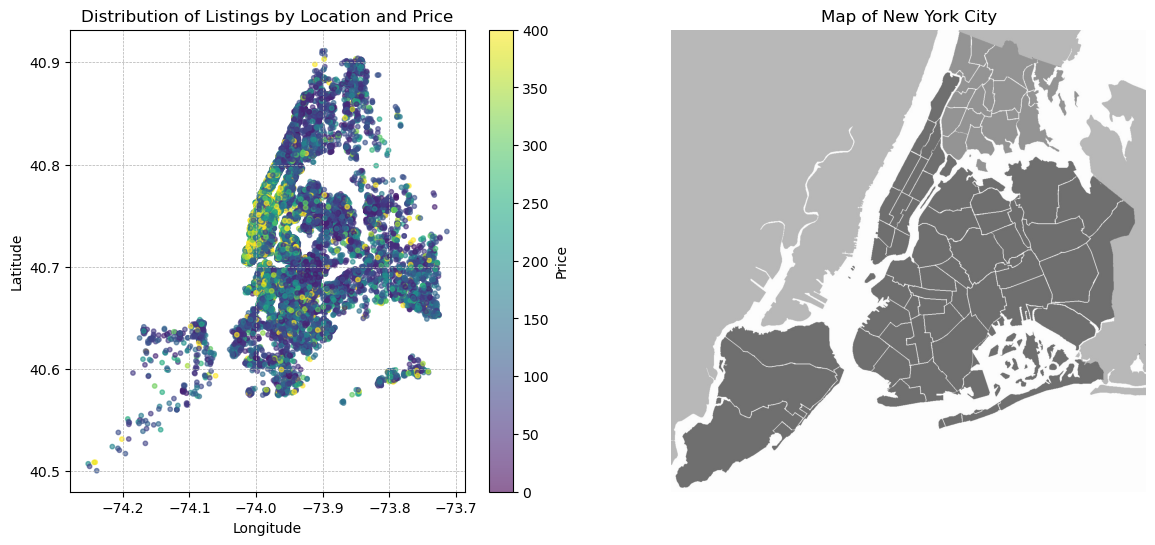

In [30]:
# Fig. 2
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14, 6))

# Setting color limits to more typical range, e.g., 0 to 400
# Adjust these values based on your specific dataset and its distribution
vmin, vmax = 0, 400

ax[0].scatter(train_df['longitude'], train_df['latitude'], c=train_df['price'], #cmap='viridis',
            s=10, alpha=0.6, vmin=vmin, vmax=vmax)
fig.colorbar(plt.scatter(train_df['longitude'], train_df['latitude'], c=train_df['price'], #cmap='viridis',
            s=10, alpha=0.6, vmin=vmin, vmax=vmax), label='Price', ax=ax[0])
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[0].set_title('Distribution of Listings by Location and Price')
ax[0].set(xlabel='Longitude', ylabel='Latitude')

img = mpimg.imread('images/New_York_City_Map.jpg')

ax[1].imshow(img)
ax[1].set_title('Map of New York City')
ax[1].axis("off")

**Fig. 3 Price vs Number of Reviews Coloured by Room Type Scatterplot**

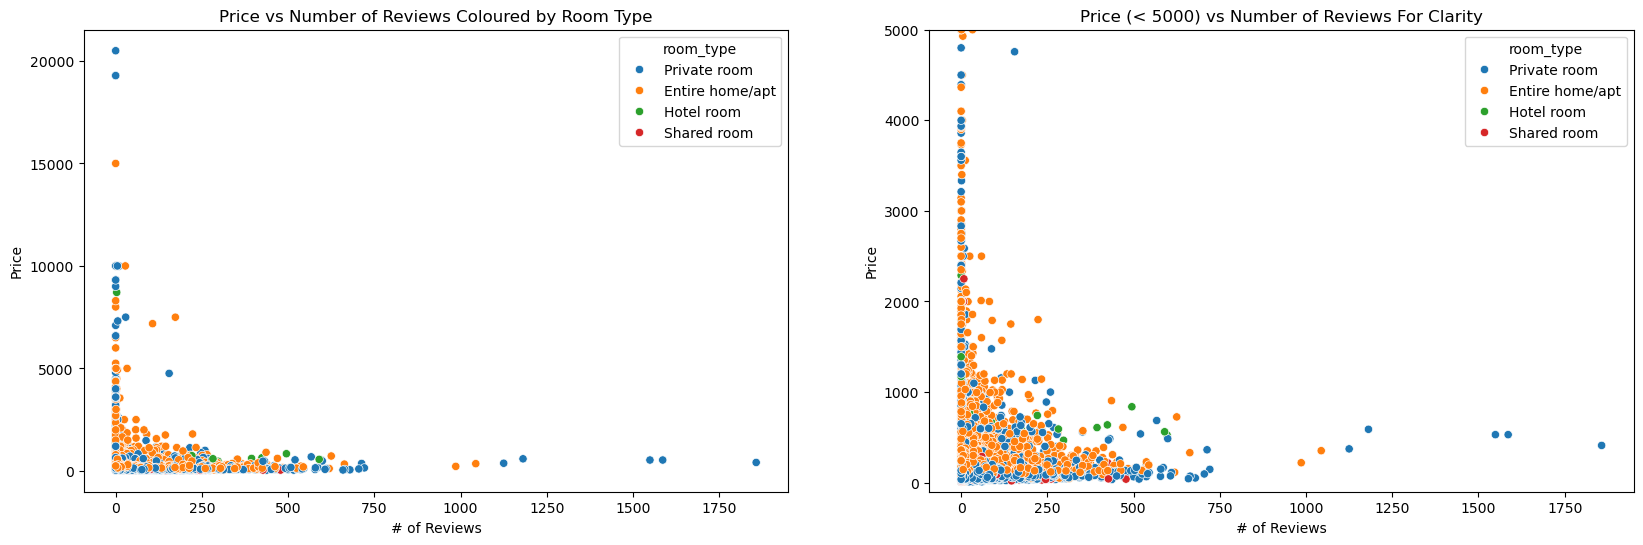

In [31]:
# Fig. 3

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))

sns.scatterplot(train_df, x = 'number_of_reviews', y='price', hue='room_type', ax=ax[0])
ax[0].set_title("Price vs Number of Reviews Coloured by Room Type")
ax[0].set(xlabel="# of Reviews", ylabel="Price")

sns.scatterplot(train_df, x = 'number_of_reviews', y='price', hue='room_type', ax=ax[1])
ax[1].set_title("Price (< 5000) vs Number of Reviews For Clarity")
ax[1].set(xlabel="# of Reviews", ylabel="Price")
ax[1].set_ylim(-100, 5000)

fig.tight_layout
plt.show()

**Fig. 4 Price vs Reviews Per Month Coloured by Room Type Scatterplot**

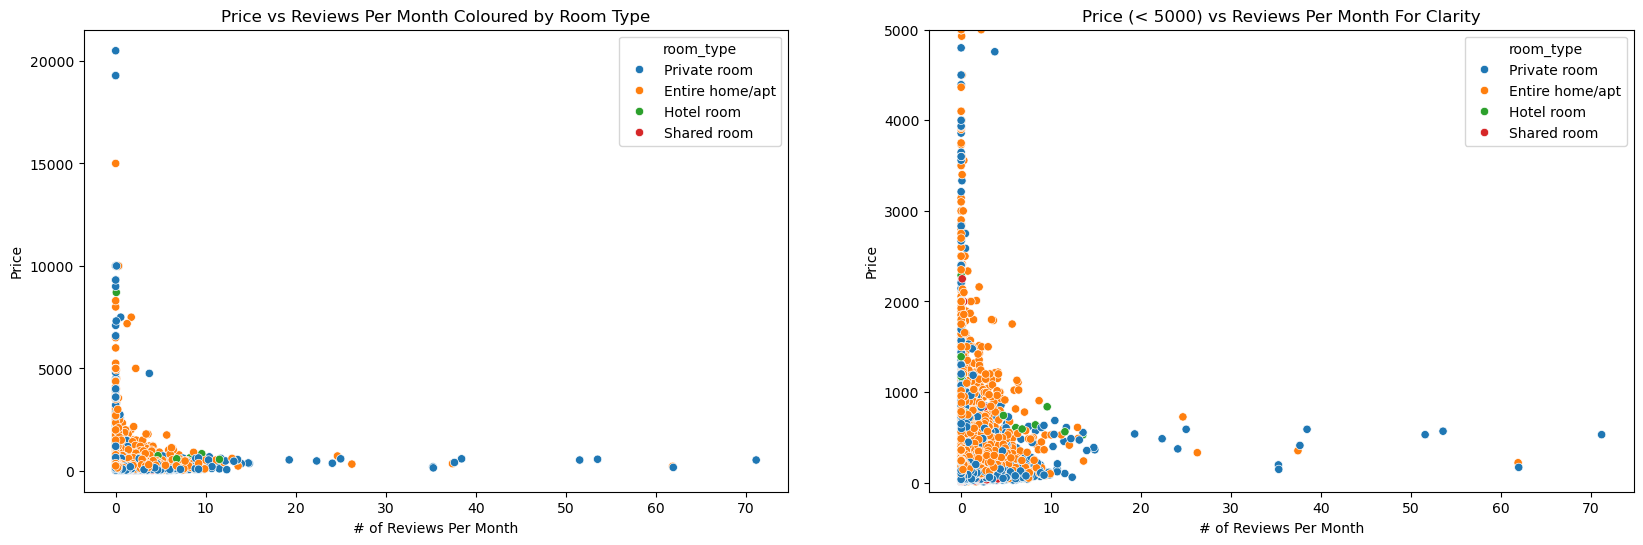

In [32]:
# Fig. 4

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))

sns.scatterplot(train_df, x = 'reviews_per_month', y='price', hue='room_type', ax=ax[0])
ax[0].set_title("Price vs Reviews Per Month Coloured by Room Type")
ax[0].set(xlabel="# of Reviews Per Month", ylabel="Price")

sns.scatterplot(train_df, x = 'reviews_per_month', y='price', hue='room_type', ax=ax[1])
ax[1].set_title("Price (< 5000) vs Reviews Per Month For Clarity")
ax[1].set(xlabel="# of Reviews Per Month", ylabel="Price")
ax[1].set_ylim(-100, 5000)

fig.tight_layout
plt.show()

**Fig. 5 Log Price and Price by Neighbourhood Group Boxplot**

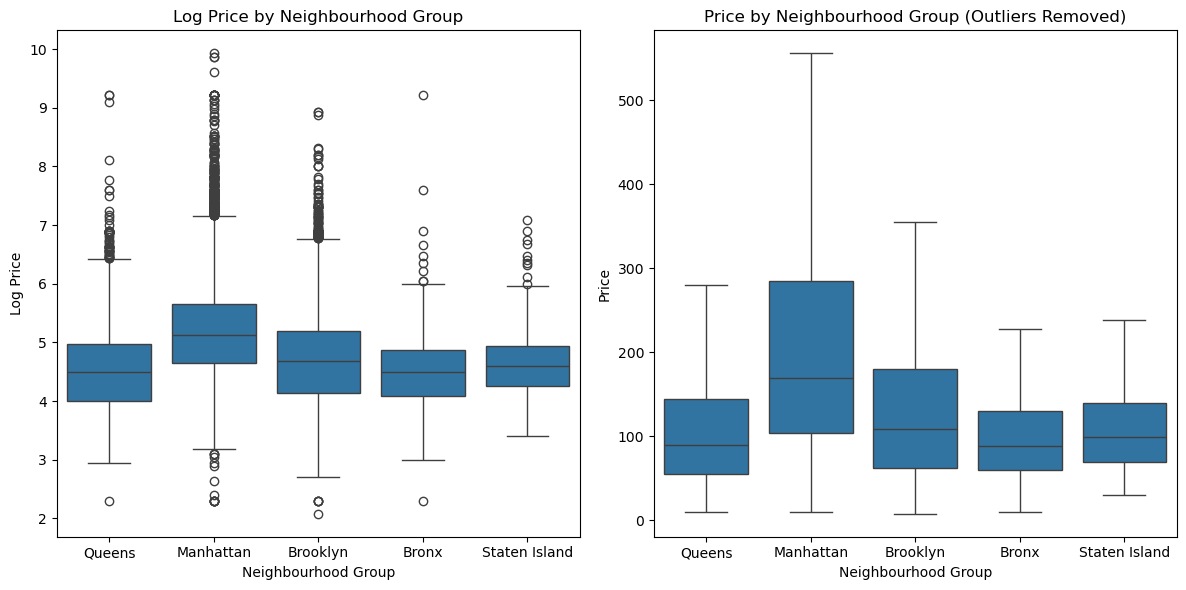

In [33]:
# Fig. 5

log_price = np.log(train_df['price'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# fig 1
sns.boxplot(x='neighbourhood_group', y=log_price, data=train_df, ax=axes[0])
axes[0].set_title('Log Price by Neighbourhood Group')
axes[0].set_xlabel('Neighbourhood Group')
axes[0].set_ylabel('Log Price')
# fig 2
sns.boxplot(x='neighbourhood_group', y='price', data=train_df, showfliers=False, ax=axes[1])
axes[1].set_title('Price by Neighbourhood Group (Outliers Removed)')
axes[1].set_xlabel('Neighbourhood Group')
axes[1].set_ylabel('Price')

plt.tight_layout() 
plt.show()

**Fig. 6 Log Price and Price by Room Type Boxplot**

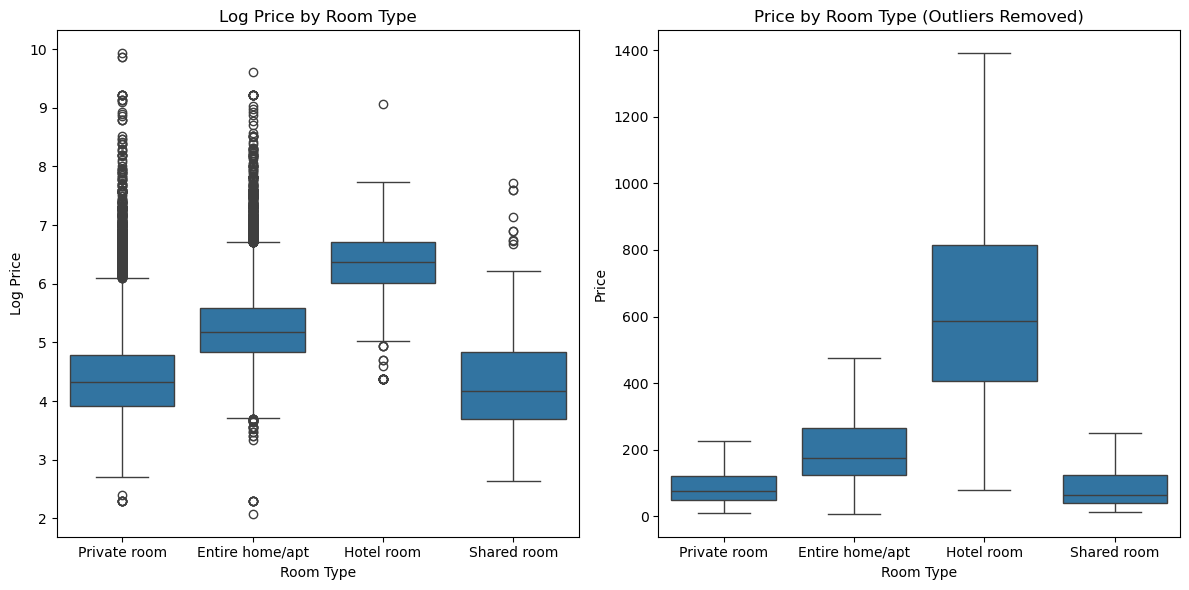

In [34]:
# Fig. 6

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(x='room_type', y=log_price, data=train_df, ax=axes[0])
axes[0].set_title('Log Price by Room Type')
axes[0].set_xlabel('Room Type')
axes[0].set_ylabel('Log Price')

sns.boxplot(x='room_type', y='price', data=train_df, showfliers=False, ax=axes[1])
axes[1].set_title('Price by Room Type (Outliers Removed)')
axes[1].set_xlabel('Room Type')
axes[1].set_ylabel('Price')


plt.tight_layout()  
plt.show()

**Fig. 7 Price Histogram (Outliers Removed)**

This will provide some insights into the distribution of price.

<bound method Figure.tight_layout of <Figure size 700x500 with 1 Axes>>

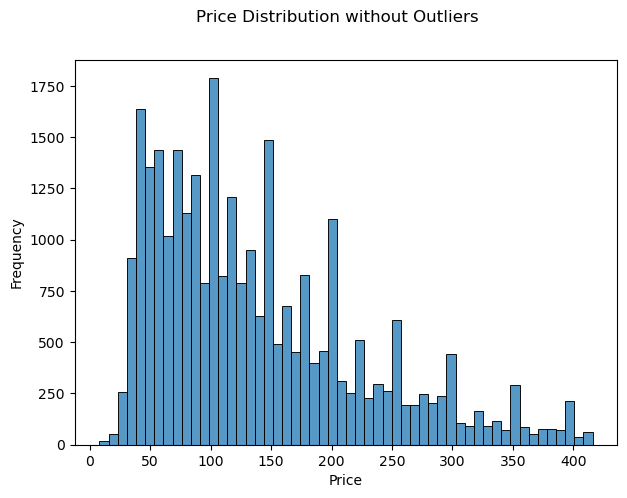

In [35]:
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


filtered_train_df = train_df[(train_df['price'] >= lower_bound) & (train_df['price'] <= upper_bound)]

fig, ax = plt.subplots(figsize=(7, 5))

sns.histplot(data=filtered_train_df, x='price')

fig.suptitle('Price Distribution without Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')

fig.tight_layout

### 4.2 Preprocessing & Transformations

**4.2.1 Defining Transformations & Preparing Data**

In [36]:
# Numerical Transformer
numerical_transformer = StandardScaler()

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Text Data Transformer
text_transformer = CountVectorizer()

In [37]:
# target column
target_data = ['price']

# numeric data
numerical_data = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm']

# text data
text_data = "name"

# drop data
drop_data = ["host_name", "host_id", "id", "license", "last_review"]

# Categorical Data
categorical_data = ['neighbourhood_group', 'neighbourhood', 'room_type']
X_train[text_data].head(3)

10527    Rental unit in Queens · ★4.83 · 1 bedroom · 1 ...
34501    Home in Queens · 1 bedroom · 1 bed · 1 private...
2059     Rental unit in New York · ★4.94 · 1 bedroom · ...
Name: name, dtype: object

**4.2.2 Encoding our y_train & y_test with ordinal encoder**

In [38]:
categories = [['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350+']]

In [39]:
ordinal_encoder = OrdinalEncoder(categories=categories)
y_train_encoded = ordinal_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_encoded = ordinal_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

**4.2.3 Making Our Preprocessor**

In [40]:
preprocessor = make_column_transformer(
    (numerical_transformer, numerical_data),
    (categorical_transformer, categorical_data),
    (text_transformer, text_data),
    remainder='drop'
)

**4.2.4 Implementing a Baseline Model**

We can implement a Dummy Regressor model as a baseline to assess our model with. 

In [113]:
dummy_model = DummyClassifier()

dummy_pipe = make_pipeline(preprocessor, dummy_model)
dummy_pipe.fit(X_train, y_train_encoded)
#f'Test Score is: {dummy_pipe.score(X_test, y_test_encoded)}'
classification_report(y_test_encoded, dummy_pipe.predict(X_test) output_dict=True)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       956
         1.0       0.28      1.00      0.43      2186
         2.0       0.00      0.00      0.00      1612
         3.0       0.00      0.00      0.00      1030
         4.0       0.00      0.00      0.00       597
         5.0       0.00      0.00      0.00       433
         6.0       0.00      0.00      0.00       252
         7.0       0.00      0.00      0.00       860

    accuracy                           0.28      7926
   macro avg       0.03      0.12      0.05      7926
weighted avg       0.08      0.28      0.12      7926



c:\Users\rashi\miniconda3\envs\dsci\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rashi\miniconda3\envs\dsci\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rashi\miniconda3\envs\dsci\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5. Model & Results

For our models we decided to create two models, firstly with a Decision tree classifier so we can analyze feature importance. Next, with a KNN method to test the accuracy of our model.

Here is a method to build our model, we built it for ease of reproducibility when creating new models. 

# Feature importance 

In [48]:
from matplotlib.pyplot import figure 
def build_model(model, preprocessor, X_train, y_train_encoded, X_test, y_test_encoded, clf=False):
    model_pipe = make_pipeline(preprocessor, model)
    model = model_pipe.fit(X_train, y_train_encoded)
    predictions = model.predict(X_test)
    return model, classification_report(y_test_encoded, predictions, output_dict=True)
        

### 5.1 Building a model using Decision Tree & Feature Importance Diagram

At present, our feature importance metrics may be distorted due to the numerous variables generated through one-hot encoding. For subsequent analyses, we might consider exploring alternative methods to evaluate feature significance, such as aggregating the importance of dummy variables back to the original categorical variables, or employing encoding techniques that preserve more information about the categorical variable's cardinality and inherent ordering. This approach could potentially provide a more accurate reflection of each feature's true contribution to the predictive model.

In [103]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model, knn_clf_report = build_model(knn, preprocessor, X_train, y_train_encoded, X_test, y_test_encoded, clf=True)
replacement_dict = {'0.0':'0-50', '1.0':'50-100', '2.0':'100-150', '3.0':'150-200', '4.0':'200-250','5.0':'250-300',
                    '6.0':'300-350', '7.0':'350+', 'accuracy':'accuracy', 'macro avg':'macro avg', 'weighted avg':'weighted avg'}
knn_clf_report = dict((replacement_dict[key], value) for (key, value) in knn_clf_report.items())
pd.DataFrame(knn_clf_report).transpose()

,precision,recall,f1-score,support
0-50,0.553381,0.650628,0.598077,956.000000
50-100,0.514813,0.612077,0.559248,2186.000000
100-150,0.386782,0.417494,0.401551,1612.000000
150-200,0.301887,0.279612,0.290323,1030.000000
200-250,0.246819,0.162479,0.195960,597.000000
250-300,0.276680,0.161663,0.204082,433.000000
300-350,0.194690,0.087302,0.120548,252.000000
350+,0.624000,0.544186,0.581366,860.000000
accuracy,0.451426,0.451426,0.451426,0.451426
macro avg,0.387382,0.364430,0.368894,7926.000000


In [76]:
preds = knn_model.predict(X_test).astype(str)
replacement_dict = {'0.0':'0-50', '1.0':'50-100', '2.0':'100-150', '3.0':'150-200', '4.0':'200-250','5.0':'250-300',
                    '6.0':'300-350', '7.0':'350+'}
newpreds = np.array([replacement_dict[x] for x in preds])
newpreds

array(['50-100', '0-50', '100-150', ..., '100-150', '300-350', '0-50'],
      dtype='<U7')

In [82]:
test_df['pred_price_category'] = newpreds

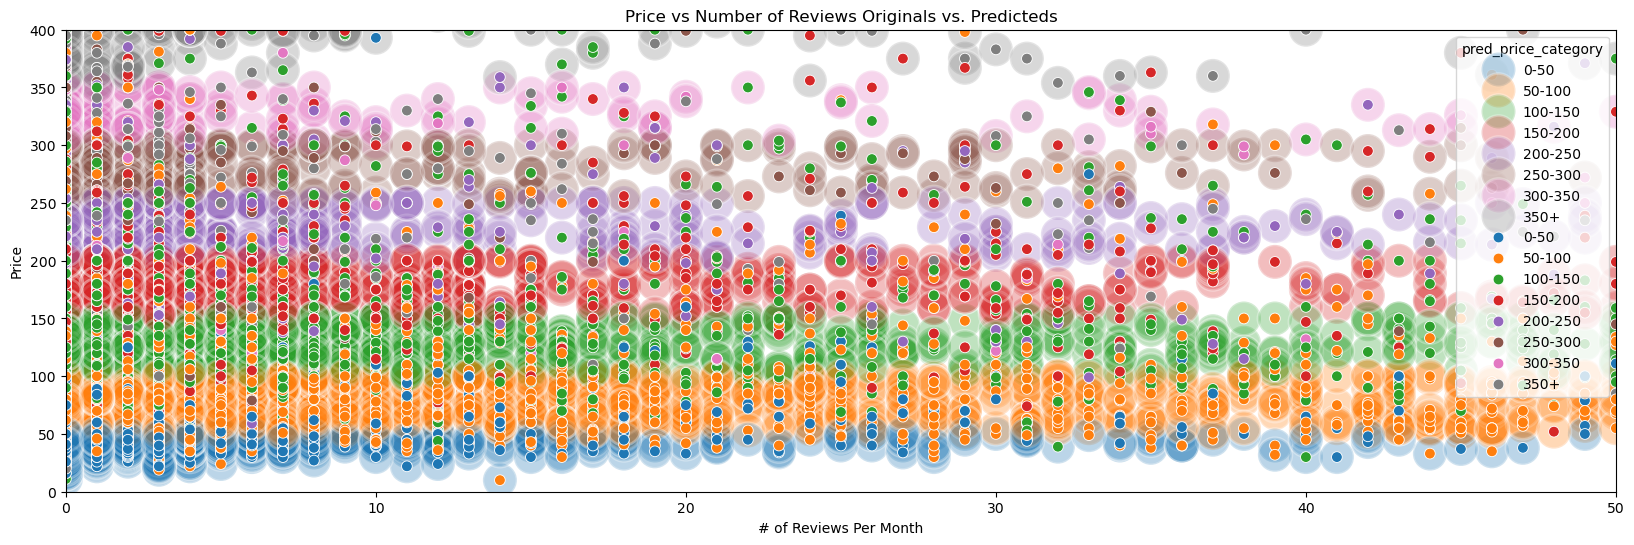

In [101]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.scatterplot(test_df, x = 'number_of_reviews', y='price', hue='price_category', s=600, alpha=0.3)

sns.scatterplot(test_df, x = 'number_of_reviews', y='price', hue='pred_price_category',
                hue_order=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350+'], s=60)
ax.set_title("Price vs Number of Reviews Originals vs. Predicteds")
ax.set(xlabel="# of Reviews Per Month", ylabel="Price")
ax.set_ylim(0, 400)
ax.set_xlim(0, 50)

fig.tight_layout
plt.show()

### 5.2 KNN Hyperparameter Optimization

In [51]:
param_dist = {
    'kneighborsclassifier__n_neighbors': randint(1, 30),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]  
}

try:
    rand_search = RandomizedSearchCV(knn_model, param_distributions=param_dist, n_iter=5,  
                                     n_jobs=-1,  
                                     scoring='accuracy', cv=3, 
                                     verbose=1, random_state=42, pre_dispatch='2*n_jobs')  
except Exception as e:
    print(f"Error with rand_search: {e}")
    rand_search = RandomizedSearchCV(knn_model, param_distributions=param_dist, n_iter=5,
                                     scoring='accuracy', cv=3, verbose=1, random_state=42)

rand_search.fit(X_train, y_train_encoded)

print("Best parameters:", rand_search.best_params_)
print("Best score:", rand_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


Best parameters: {'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}
Best score: 0.4665467966310211


In [120]:
rand_search.best_params_['kneighborsclassifier__n_neighbors']

15

#### Classification Report After Hyperparameter Optimization

In [104]:
rand_search_predictions = rand_search.predict(X_test)
hyperparam_clf_report = classification_report(y_test_encoded, rand_search_predictions, output_dict=True)
hyperparam_clf_report = dict((replacement_dict[key], value) for (key, value) in hyperparam_clf_report.items())
pd.DataFrame(hyperparam_clf_report).transpose()

,precision,recall,f1-score,support
0-50,0.643865,0.620293,0.631859,956.000000
50-100,0.556753,0.661940,0.604807,2186.000000
100-150,0.408281,0.440447,0.423754,1612.000000
150-200,0.312500,0.315534,0.314010,1030.000000
200-250,0.268409,0.189280,0.222004,597.000000
250-300,0.345794,0.170901,0.228748,433.000000
300-350,0.343434,0.134921,0.193732,252.000000
350+,0.615901,0.639535,0.627496,860.000000
accuracy,0.485238,0.485238,0.485238,0.485238
macro avg,0.436867,0.396606,0.405801,7926.000000


## 6. Discussion

Our investigation utilized an KNN machine learning algorithm to estimate pricing categories for Airbnb listings in New York City. The dataset was divided using an 80/20 train-test split, and we processed features as either numerical or categorical to forecast the prices within predetermined ranges. The model achieved an accuracy of 0.48 as indicated in the classification report above, which is not the best however, considering the complexity of the pricing structure in the short-term rental market it performed decently. 

The level of accuracy attained was anticipated to some extent. We undertook a meticulous selection of predictive variables and addressed missing values to enhance the model's precision. However, the modest F1-score indicates the model could benefit from improvements such as better feature selection and feature engineering. This could be done through performing feature importance analysis and working with that information to further develop our model. We created a model with a KNN to test.

The implications of such a model are significant. For renters, it could mean a more informed decision-making process, as they could benchmark individual rental prices against the broader market. Landlords might utilize the model to set competitive prices, ensuring their offerings are in line with current market conditions.

Moving forward, this study opens up several avenues for further inquiry. One such area is the incorporation of temporal dynamics into the model, as pricing could be influenced by seasonal trends or significant events. Continuous refinement of the model is essential to maintain its relevance, as the short-term rental market is subject to frequent fluctuations. Additionally, investigating the outliers and misclassified instances could provide insights into the limitations of the current model and guide enhancements in predictive accuracy.

## 7. References

Bellafante, G. (2024, February 9). Can a new law force airbnb hosts to become landlords? *The New York Times.* Retrieved from https://www.nytimes.com/2024/02/09/nyregion/nyc-airbnb-rentals.html#:~:text=In%20May%202022%2C%20there%20were,and%20Newark%20exceeded%2053%20percent.

Chan, W. (2023, October 23). ‘We’re in a housing desert’: a month in, is new york’s airbnb crackdown working? *The Guardian.* Retrieved from https://www.theguardian.com/us-news/2023/oct/23/new-york-airbnb-crackdown-rules-housing.

Fields, S. (2023, August 24). *Can an airbnb crackdown really make New York more affordable?.* Marketplace. https://www.marketplace.org/2023/08/24/new-york-city-airbnb-crackdown-affordable-housing/

Geron, T. (2009, June 10). From crash pad to pizza profitable, start-up eyes budget travel market. *The Wall Street Journal.* Retrieved from https://www.wsj.com/articles/BL-VCDB-2042.

Kelly, G. (2023, December 21). *New York City’s airbnb ban is driving up hotel prices.* The Daily Upside. https://www.thedailyupside.com/industries/consumer/new-york-citys-airbnb-ban-is-driving-up-hotel-prices/ 

Oladipo, G. (2023, September 6). New york city’s crackdown on airbnb and short-term rentals goes into effect. *The Guardian.* Retrieved from https://www.theguardian.com/us-news/2023/sep/06/airbnb-new-rental-regulation-nyc-housing.

*New York City.* Inside Airbnb: Home. (2024, February 6). http://insideairbnb.com/new-york-city

Tun, Z. T. (2023, September 5). *Top cities where Airbnb is legal or illegal.* Investopedia. https://www.investopedia.com/articles/investing/083115/top-cities-where-airbnb-legal-or-illegal.asp